# About Donorschoose.org


DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.



Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: 
* How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
* How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
* How to focus volunteer time on the applications that need the most assistance</li>
   


The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

## Understand the DonorsChoose Data Set's Attributes

There are two files:   1.train_data.csv(consists 17 features)

                2.resources.csv(consists 4 features)

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### importing all necessary modules

In [1]:
#import all necessary modules
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import sqlite3
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import os

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors



from tqdm import tqdm
import os

from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import model_selection  
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import gensim


## 1. Reading Data

In [2]:
#load two datafiles into the dataframe
project_data = pd.read_csv('train_data.csv')
resources_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)

print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
#dataframe
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [5]:
#dataframe
resources_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
#print number of datapoints and columns in resources_data
print('number of datapoints in resources_data:',resources_data.shape)
print("*"*60)
print('total features in resources_data:', resources_data.columns)

number of datapoints in resources_data: (1541272, 4)
************************************************************
total features in resources_data: Index(['id', 'description', 'quantity', 'price'], dtype='object')


**observation:**
* in project data we have 109248 datapoints(rows) and 17 features (columns).
* in resources_data we have 1541272 datapoints and  4 features(columns)

**'Project_is_approved'** Attribute:
* in the project_proposal_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

# 2. text preprocessing ( text data& categorical data)

**remove and replace  unwanted symbols, special charecters and words**

In [7]:
catogories = list(project_data['project_subject_categories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [8]:
project_data['clean_proj_categories'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_categories'], axis=1, inplace=True) #remove that previous subject_catogery attribute.

### 2.2 project_grade_category

In [9]:
catogories = list(project_data['project_grade_category'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
l = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        j = j.replace(' ','_') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('-','_') 
    l.append(temp.strip())
# l is list with all cleaned categories.

In [10]:
project_data['clean_proj_grade'] = l    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_grade_category'], axis=1, inplace=True) #remove that previous grade_catogery attribute.

### 2.3  project_subject_subcategories

In [11]:
catogories = list(project_data['project_subject_subcategories'].values)
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
lst = []  #creat empty list
for i in catogories:      #each category ex"math&Scince" in catogeries ex[["Math & Science", "Warmth", "Care & Hunger"]]
    temp = ""       #empty
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts 
        if 'The' in j.split(): # this will split each of the catogory based on space 
            j=j.replace('The','') # if we have the words "The" we are going to replace it with '' empty
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) 
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') 
    lst.append(temp.strip())
#lst is list with all cleaned subcategories.

In [12]:
project_data['clean_proj_subcategories'] = lst    #creat new attribute and store all cleaned catogeries into that attribute, 
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True) #remove that previous subject_subcatogery attribute.

## 2.4 Text Preprocessing
###  Project Essay's

there are we have 4 essays's:
   1.  project_essay_1 
   2.  project_essay_2
   3.  project_essay_3 
   4.  project_essay_4
* so we have to  merge(combilne) 4 essays into one single essay.

In [13]:
# merge all essay columns into single essay columns 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [14]:
#remove that previous project_essay_1,2,3 and 4
project_data.drop(["project_essay_1"], axis=1, inplace=True) 
project_data.drop(["project_essay_2"], axis=1, inplace=True) 
project_data.drop(["project_essay_3"], axis=1, inplace=True) 
project_data.drop(["project_essay_4"], axis=1, inplace=True) 

In [15]:
# to observe the random esssay text data
print(project_data['essay'].values[102])

Hello!, thank you for wanting to learn more about my class! My students are Deaf and Hard-of-Hearing. The ages range from 6-8 years old. They don't have a lot of the life experiences as other students do. Almost all of my class qualifies for free lunch. Some of them ride the bus for over an hour a day (one way) to get to school. I would like to make learning fun and interactive.\r\n\r\nThey don't have access to language as other students. I want my students to become engaged in their learning and be able to interact with it. I can show them pictures in a book but then I have to put the book down so I can sign the story. So they lose the visual. It isn't possible to sign and hold a book at the same time.\r\n\r\nMy classroom is special because my students require a lot of visual aids and pictures.  I would love to show them a video of a whale or show them pictures about what we are learning.This technology would benefit my students so much. They would be able to see the text or book that

**observation**
* In the above essay feature  there are lot of unnecessary  special charecters and some other  words so we have to clean text data

In [16]:
# expand contractions

# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/nagesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
d = stopwords.words('english')
print(set(d))
print(len(d))


{'a', 'and', 'who', "it's", 'all', 're', 'ours', 'but', 'for', 'until', 't', 'we', 'your', 'couldn', 'again', "isn't", 'above', 'down', 'ma', "shan't", 'most', 'doesn', 'because', 'off', "couldn't", 'such', 'as', 'd', 'other', 'its', 'yourself', 'shouldn', "you'd", 'those', 'was', 'being', 'can', "hasn't", "wouldn't", 'by', 'so', 'o', 'is', 'isn', 'some', 'ain', 'am', 'should', 'won', 'does', 'nor', 'during', 'while', 'mustn', "haven't", 'myself', 'do', 'of', "you've", 'before', "don't", 'have', 'having', "weren't", 'out', "mightn't", 'are', 'she', 'hasn', "wasn't", 'where', 'needn', "you'll", 'further', 'will', 'their', 'from', 'hers', 'did', "hadn't", 'into', 'here', 'theirs', 'just', 'few', "that'll", 'what', 'each', 'be', 'don', "mustn't", 'haven', 'whom', 'why', 'after', 'they', "didn't", 'yours', 'against', 's', 'hadn', 'there', 'on', 'only', 'up', 'too', 'any', 'you', 'i', 'll', 'or', 'wouldn', 'that', 'more', 'been', 'doing', 'my', 'm', 'own', 'aren', 'himself', 'mightn', 'whic

#### note: we should remove some  words('no', 'nor', 'not') from stop words 

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 2.3.1 text preprocessing project_essay

In [20]:
#replace & remove some unneccesary words in text
import re
from tqdm import tqdm
preproccessed_essay_text = []
# tqdm is for printing the status bar
for sent in tqdm(project_data['essay'].values):    #all text data in essay feature 
    s = decontracted(sent)                  #function calling for expand contraction words
    s = s.replace('\\r', ' ')                   #replacing \\r with space
    s = s.replace('\\"', ' ')                   #replacing \\"', with space
    s = s.replace('\\n', ' ')                   #replacing \\n with space
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_essay_text.append(s.lower().strip())   #all sentences into lower case.

100%|██████████| 109248/109248 [01:01<00:00, 1763.00it/s]


In [22]:
project_data['preproccessed_essay_text'] = preproccessed_essay_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['essay'], axis=1, inplace=True) #remove that previous essay attribute.

### 3.2.2 Text preprocessing project_Title

In [23]:
# to observe the some random title text data
print(project_data['project_title'].values[12])
print("*"*40)
print(project_data['project_title'].values[1640])
print("*"*40)

Building Life Science Experiences
****************************************
Scientists at Work Need Materials
****************************************


#### text preprocessing project_title

In [24]:
from tqdm import tqdm
preproccessed_title_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_title'].values):    #all text data in essay feature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_title_text.append(s.lower().strip())   #all sentences into lower case.

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 59399.05it/s]


In [25]:
project_data['preproccessed_title_text'] = preproccessed_title_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_title'], axis=1, inplace=True) #remove that previous project title attribute.

#### Text preprocessing project_resource_summary

In [26]:
from tqdm import tqdm
preproccessed_resource_text = []
# tqdm is for printing the status bar
for sentence in tqdm(project_data['project_resource_summary'].values):    #all text data in project_resource_summaryfeature 
    s = decontracted(sentence)                  #function calling for expand contraction words
    s = re.sub('[^A-Za-z0-9]+', ' ', s)      #selection charecters only between Ato Z, a-z and 0-9.
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in s.split() if e not in stopwords) #removing stopwords
    preproccessed_resource_text.append(s.lower().strip())   #all sentences into lower case.

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:04<00:00, 25631.50it/s]


In [27]:
project_data['preproccessed_prjct_resource_summary'] = preproccessed_resource_text    #creat new attribute and store all cleanedessay text into that attribute, 
project_data.drop(['project_resource_summary'], axis=1, inplace=True) #remove that previous resource_text attribute.

## 2.3.4 dataframe after text preprocessed features

In [28]:
#print top 4 data points  after text preprocessed features
project_data.head(4)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,4,1,Literacy_Language Math_Science,Grades_PreK_2,Literacy Mathematics,i work at a unique school filled with both esl...,techie kindergarteners,my students need to engage in reading and math...


## 2.4 Join two dataframe(project_proposal_data and resources_data) based on ID

In [29]:
#to get price of the project
resources_data.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


In [30]:
#https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
#from resources data  coulumns group by id and sum values of two columns
price_data = resources_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(3)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21
2,p000003,298.97,4


In [31]:
#join(merge) two data frames based on id
project_data = pd.merge(project_data, price_data, on='id', how='left')  #how=lef if any remaining data present in any df that will be merge with dataframe

In [32]:
#shape of the final merged dataframe
project_data.shape

(109248, 16)

we have 109248 datapoints and 16 features

## print final data frame

In [33]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,7,1,History_Civics Health_Sports,Grades_6_8,Civics_Government TeamSports,our students arrive to our school eager to lea...,wanted projector for hungry learners,my students need a projector to help with view...,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,1,0,Health_Sports,Grades_6_8,Health_Wellness TeamSports,true champions are not always the ones that wi...,soccer equipment for awesome middle school stu...,my students need shine guards athletic socks s...,516.85,22


**replacing nan value with 'no_prefix in' techer_prefix categoric feature**

In [34]:
#https://datatofish.com/replace-nan-values-with-zeros/
project_data['teacher_prefix'] =project_data['teacher_prefix'].replace(np.nan, 'no_prefix')

In [35]:
pro_categoric = project_data.groupby('teacher_prefix')

lstt = []
for fl1,gfl1 in  pro_categoric:
    
    lstt.append(fl1)
    
print("length of all grouped categories:",len(lstt))  ##number of subcategories
print("all categories in  project grade:",lstt)

length of all grouped categories: 6
all categories in  project grade: ['Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher', 'no_prefix']


In [36]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,teacher_number_of_previously_posted_projects,project_is_approved,clean_proj_categories,clean_proj_grade,clean_proj_subcategories,preproccessed_essay_text,preproccessed_title_text,preproccessed_prjct_resource_summary,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,0,0,Literacy_Language,Grades_PreK_2,ESL Literacy,my students are english learners that are work...,educational support for english learners at home,my students need opportunities to practice beg...,154.6,23


## 2.5.1 (identify) select the class lable 

according to the above dataframe 
**'Project_is_approved'** Attribute:
* in the project_data' dataframe we have  'project is approved'  Attribute, it consists with 2 values that are [1]Number of projects approved and [0] number of projects not approved.

In [37]:
#y is class label
y = project_data['project_is_approved'].values       #storing all project_is approved attribute values in y variable
project_data.drop(['project_is_approved'], axis=1, inplace=True)    #eliminate the project_is_approved attribute from dataframe


# 2.6 Splitting data

### split data into train, cross validation and test data

In [38]:
# splitting into train, crossvalidation and test data
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(project_data, y, test_size=0.33, stratify=y)  # split 33% data in test data and  67% in train data
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  #split train data into train and cross_valiadation

our total dataset splitted into train data, cross validation data and test data.

In [39]:
#print shape of splitted data
print("data before feature vectorizing:")
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

data before feature vectorizing:
(49041, 15) (49041,)
(24155, 15) (24155,)
(36052, 15) (36052,)


**observation**
* there are 22445 datapoints in train data.
* 11055 datapoints in cross validation data.
* 16500 datapoints in test data.

# 2.7 Creating Data Matrix

# 2.8 feature vectorization (BOW)

## 2.8.1 converting the preproccessed_essay_text to vectors(bag of words)

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_essay_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_bow = vectorizer1.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_bow = vectorizer1.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_bow = vectorizer1.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


* after BOW vecterization we have X_train data 49041 data points with 5000 features
* in x_cv 24155 datapoints, 5000features
* in x_test 36052 datapoints, and 5000 features

## 2.8.2 converting the preproccessed_title_text to vectors(bag of words)

In [41]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000) #select maximum vectorized features = 5000
vectorizer1.fit(X_train['preproccessed_title_text'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_bow = vectorizer1.transform(X_train['preproccessed_title_text'].values)
X_cv_title_bow = vectorizer1.transform(X_cv['preproccessed_title_text'].values)
X_test_title_bow = vectorizer1.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)


************************************************************
After vectorizations:
(49041, 4768) (49041,)
(24155, 4768) (24155,)
(36052, 4768) (36052,)


# 2.9 feature vectorization (TFIDF)

## 2.9.1 converting the preproccessed_essay_text to vectors(TFIDF)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2.fit(X_train['preproccessed_essay_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_essay_tfidf = vectorizer2.transform(X_train['preproccessed_essay_text'].values)
X_cv_essay_tfidf = vectorizer2.transform(X_cv['preproccessed_essay_text'].values)
X_test_essay_tfidf = vectorizer2.transform(X_test['preproccessed_essay_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 5000) (49041,)
(24155, 5000) (24155,)
(36052, 5000) (36052,)


## 2.9.2 converting the preproccessed_title_text to vectors(TFIDF)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram_range=(1,2) selecting unigrams and bigrams
vectorizer2 = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)#select maximum vectorized features = 5000
vectorizer2.fit(X_train['preproccessed_title_text'].values)
# applying  learned parameters (vocabulary) to the train, cv and cross validation
X_train_title_tfidf = vectorizer2.transform(X_train['preproccessed_title_text'].values)
X_cv_title_tfidf = vectorizer2.transform(X_cv['preproccessed_title_text'].values)
X_test_title_tfidf = vectorizer2.transform(X_test['preproccessed_title_text'].values)

print("*"*60)
print("After vectorizations:")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)

************************************************************
After vectorizations:
(49041, 4768) (49041,)
(24155, 4768) (24155,)
(36052, 4768) (36052,)


# 2.10 feature vectorization (AVGW2V)

## 1. Training W2V model

In [44]:
#import word2vec 
from gensim.models import Word2Vec   #to make own w2vec model
from gensim.models import KeyedVectors   #w2v model by googlenews-300.bin
from tqdm import tqdm
import numpy as np

#### 1.1 Preparing list of list with sentences for model

In [45]:
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [46]:
# train w2v model on  list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 6 if word  atleast 6times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [47]:
w2v_words = list(w2v_model.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 4 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 4 times  15811
sample_w2v_ words  ['my', 'students', 'are', 'very', 'sweet', 'and', 'loving', 'kids', 'they', 'absolutely', 'love', 'having', 'fun', 'in', 'classroom', 'their', 'favorite', 'thing', 'to', 'do', 'is', 'read', 'a', 'good', 'fit', 'book', 'take', 'an', 'accelerated', 'reader', 'test', 'on', 'it', 'receive', 'new', 'books', 'hear', 'of', 'amazing', 'series', 'just', 'warms', 'heart', 'see', 'the', 'excitement', 'faces', 'when', 'i', 'get', 'them', 'build', 'reading', 'third', 'grade', 'lifelong', 'will', 'keep', 'with', 'this']


total words 11639 wich are occured atleast 4 times in model trained vocubulary words

## 2.10.1 converting the preproccessed_essay_text to vectors(AVGW2V)

##  I. Converting Train data  essay text to AVGW2V

In [48]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_train data.
X_train_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_essay_avgw2v.append(sent_vec)
X_train_essay_avgw2v = np.array(X_train_essay_avgw2v)  #converting all essay word2vec words into array
print(X_train_essay_avgw2v.shape)
print(X_train_essay_avgw2v[2])

100%|███████████████████████████████████████████████████████████████████████████| 49041/49041 [02:32<00:00, 322.50it/s]


(49041, 50)
[-0.35611614 -0.19773729  0.15160899 -0.03380087 -1.24138744 -0.01252811
  0.70321228 -0.91633871  0.23642748 -0.30104412  0.12984657  0.05189525
  0.26173426 -0.40087021 -0.92256356 -0.04355084  0.82965538  0.49949556
 -0.34038159  0.75564079 -0.26389112 -0.75100571  0.16359925  0.01725465
 -0.0262483  -0.63643869 -0.41932559 -0.32965762  0.53091695 -0.46928183
  0.26680121  0.56081867 -0.77787806 -0.23970301 -0.15022325  0.23169726
  0.0656052  -0.18860932  0.84237026  0.83760795  1.15296333 -0.08100762
  0.06559705  0.57620561 -0.8484153   0.29359535  0.91186268 -0.08208534
  0.5883643  -1.23609047]


## II. Converting Cross_Validation  essay data text to AVGW2V

In [49]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [50]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_essay_avgw2v.append(sent_vec)
X_cv_essay_avgw2v = np.array(X_cv_essay_avgw2v)  #converting all essay word2vec words into array
print(X_cv_essay_avgw2v.shape)
print(X_cv_essay_avgw2v[2])

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [01:16<00:00, 315.34it/s]


(24155, 50)
[-1.08457389e-01 -7.02092776e-01 -4.31436042e-01  1.79480410e-01
 -1.45415754e+00  4.15695700e-03  6.58108306e-01 -8.66510216e-01
  2.60086976e-01 -4.54599834e-01 -4.27421322e-01 -3.61598856e-01
  2.11568502e-01 -3.06865787e-01 -6.04217806e-01 -3.64400085e-01
  8.57733198e-01  1.28715985e-01 -4.33975327e-01  6.18420608e-01
 -4.72102308e-01 -7.45150183e-01  7.43300781e-02  3.70311340e-01
  9.48282698e-02 -6.07104759e-01 -3.84596796e-01 -1.43914707e-01
  4.84717593e-01 -6.76284428e-01  3.61615482e-01  5.27848329e-01
 -8.73349099e-01 -4.71849356e-02 -4.49706886e-01 -1.34952021e-01
  1.18702180e-02 -3.87575444e-01  6.64112551e-01  6.17499303e-01
  9.03968938e-01  3.11865175e-01  2.47248895e-01  3.52231105e-01
 -1.03955202e+00  2.69237226e-01  1.05404468e+00 -7.34576265e-05
  6.60335427e-01 -1.15469438e+00]


## III. Converting Test  essay data text to AVGW2V

In [51]:
i = 0
list_of_sentance_test=[]  #empty list 
for sentance in X_test['preproccessed_essay_text'].values:  #for ecah sentence(text)  in  essay text cv data
    list_of_sentance_test.append(sentance.split())   #append in list (list of lists with   sentences)

In [52]:
# average Word2Vec
# compute average word2vec for each datapoint in essay_test data.
X_test_essay_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_essay_avgw2v.append(sent_vec)
X_test_essay_avgw2v = np.array(X_test_essay_avgw2v)  #converting all essay word2vec words into array
print(X_test_essay_avgw2v.shape)
print(X_test_essay_avgw2v[2])

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:54<00:00, 313.72it/s]


(36052, 50)
[ 0.3937528  -0.17779105 -0.25998398 -0.07089245 -0.81452442 -0.03901182
  0.36384417 -0.46901593  0.02420338 -0.07126481 -0.42257397 -0.2273249
 -0.06925432 -0.64462043 -0.52155778 -0.44771311  0.99609161  0.23594451
 -0.18512209  0.35891766 -0.45909591 -0.61315953  0.13541475  0.23785808
 -0.04052452 -0.516945   -0.3665555  -0.27137308  0.07879938 -1.05334469
  0.41252825  0.21060174 -0.82243165  0.41785332 -0.46961993  0.22757214
 -0.56844834 -0.16831047  1.12176079  0.49862122  0.61957769  0.22749635
 -0.11570285  0.34624761 -0.85281836  0.02304734  0.75083393  0.05817726
  0.43102353 -0.60564451]


## 2.10.2 converting the preproccessed_title_text to vectors(AVGW2V)

### 1. Training W2V model

#### 1.1 Preparing list of list with sentences for model

In [224]:
i = 0
list_of_sentance_train1=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  title text train data
    list_of_sentance_train1.append(sentance.split())   #append in list (list of lists with   sentences)

### 1.2 train Word2Vec on train data(list of sentences)

In [226]:
# train w2v model on  list of sentances
w2v_model1=Word2Vec(list_of_sentance_train1,min_count=6,size=50, workers=4)
#list of sentence [['w1'],['w2']....] in train essay data, min_count = 4 if word  atleast 4 times occure then it will be consider
#size = 50 w-->vec dimensions, workers=4  multicore of computer(laptop)

In [227]:
w2v_words = list(w2v_model1.wv.vocab)     #model trained vocubulary words
print("all words occured minimum 6 times ",len(w2v_words))
print("sample_w2v_ words ", w2v_words[0:60])   #print 40 words

all words occured minimum 6 times  2980
sample_w2v_ words  ['reading', 'is', 'fun', 'for', 'everyone', 'why', 'sit', 'down', 'when', 'you', 'were', 'to', 'stand', 'up', 'the', 'key', 'help', 'our', 'track', 'team', 'get', '1st', 'graders', 'need', 'new', 'books', 'wiggle', 'seats', 'we', 'love', 'read', 'leer', 'r', 'n', 'opening', 'eyes', 'with', 'world', 'news', 'effective', 'communication', 'supplies', 'what', 'in', 'water', 'take', 'your', 'seat', 'choose', 'how', 'learn', 'best', 'teaching', 'technology', 'comes', 'school', 'book', 'study', 'wobble', 'and']


## I. Converting  title Train data  text to AVGW2V

In [230]:
# average Word2Vec
# compute average word2vec for each datapoint in title_train data.
X_train_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_train): # for each sentence in list_of_sentance_train
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_title_avgw2v.append(sent_vec)
X_train_title_avgw2v = np.array(X_train_title_avgw2v)  #converting all title word2vec words into array
print(X_train_title_avgw2v.shape)


100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:02<00:00, 19352.24it/s]


(49041, 50)


## II. Converting Title Cross_Validation   data text to AVGW2V

In [57]:
i = 0
list_of_sentance_cv=[]  #empty list 
for sentance in X_cv['preproccessed_title_text'].values:  #for ecah sentence(text)  in  title text cv data
    list_of_sentance_cv.append(sentance.split())   #append in list (list of lists with   sentences)

In [58]:
# average Word2Vec
# compute average word2vec for each datapoint in cv data.
X_cv_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_cv): # for each sentence in list_of_sentance_cv
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_title_avgw2v.append(sent_vec)
X_cv_title_avgw2v = np.array(X_cv_title_avgw2v)  #converting all title word2vec words into array
print(X_cv_title_avgw2v.shape)
print(X_cv_title_avgw2v[3])

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 19419.95it/s]


(24155, 50)
[ 0.00144641 -0.0340684  -0.1527957   0.24045319  0.78121995 -0.15253991
 -0.37010064 -0.14064717 -0.22134505  0.00142442  0.28599401  0.18297628
  0.47076505  0.07650413  0.13926575  0.22081497 -0.36513668  0.0977135
  0.39482316  0.0204276   0.58422826  0.05586289 -0.049391   -0.01303859
 -0.21093525  0.1092034  -0.3492414  -0.01283673 -0.28326431  0.11319852
  0.05881315 -0.08293873  0.21026518  0.45686822  0.26747031 -0.17649242
  0.15530291 -0.07738989  0.15018516  0.22851442  0.06324598  0.22939099
 -0.04179649 -0.44388418  0.49813274  0.00289752  0.01906647  0.04361871
  0.13603141 -0.06609937]


## III. Converting  Title Test data text to AVGW2V

In [59]:
# average Word2Vec
# compute average word2vec for each datapoint in title_test data.
X_test_title_avgw2v = [] 
for sent in tqdm(list_of_sentance_test): # for each sentence in list_of_sentance_test
    sent_vec = np.zeros(50) # select maximum features = 50, ifwe use google's w2v then might select 300 features
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sent: # for each word in a sentence
        if word in w2v_words:       #if true
            vec = w2v_model.wv[word]      
            sent_vec += vec
            cnt_words += 1    #count how many words are similar in w2v model
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_title_avgw2v.append(sent_vec)
X_test_title_avgw2v = np.array(X_test_title_avgw2v)  #converting all title word2vec words into array
print(X_test_title_avgw2v.shape)
print(X_test_title_avgw2v[2])

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:41<00:00, 354.00it/s]


(36052, 50)
[ 0.07281456 -0.03842143 -0.19130616  0.44530706  0.70304553 -0.18574287
 -0.34735239 -0.16338675  0.16276256  0.17026904  0.36188102 -0.04342778
  0.77128972 -0.17060258  0.3028737   0.38488169 -0.25730975  0.22469439
  0.61706529  0.02891176  0.49861839 -0.04405526  0.10050021 -0.07969743
 -0.029896    0.29738411 -0.11267036  0.14002425 -0.00965088  0.1525037
 -0.07793077 -0.07469673  0.36965255  0.75944485  0.61310263 -0.22992549
 -0.03993927 -0.20675576 -0.08183179  0.14396604  0.17863612  0.34808267
  0.01330438 -0.7745896   0.35238717 -0.17346393 -0.0744258   0.33108783
  0.08695476  0.21877839]


# 2.11 feature vectorization (TFIDF-W2V)

## 2.11.1  Converting  Essay  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [60]:
# Preparing list of list with sentences for model
#train Word2Vec on train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_essay_text'].values:  #for ecah sentence(text) in  essay text train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [61]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_essay_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  Essay Train data  text to TFIDF-W2V

In [62]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_essay_text'].values): # for each sentence in train essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_essay_tfidfw2v.append(vector)

print(len(X_train_essay_tfidfw2v))
print(len(X_train_essay_tfidfw2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 49041/49041 [04:12<00:00, 194.15it/s]


49041
50


## II. Converting  Essay CV data  text to TFIDF-W2V

#### word2vec model and tfidf model already fit on train data

In [63]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_essay_text'].values): # for each sentence in cv essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_essay_tfidfw2v.append(vector)

print(len(X_cv_essay_tfidfw2v))
print(len(X_cv_essay_tfidfw2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 24155/24155 [02:04<00:00, 193.37it/s]


24155
50


## III. Converting  Essay TEST data  text to TFIDF-W2V

In [64]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_essay_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_essay_text'].values): # for each sentence in test essaty data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_essay_tfidfw2v.append(vector)

print(len(X_test_essay_tfidfw2v))
print(len(X_test_essay_tfidfw2v[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [03:04<00:00, 195.30it/s]


36052
50


## 2.11.2 Converting  Title  data  text to TFIDF-W2V

### 1. Training W2V model on train data

In [65]:
# Preparing list of list with sentences for model
#train Word2Vec on title train data(list of sentences)
i = 0
list_of_sentance_train=[]  #empty list 
for sentance in X_train['preproccessed_title_text'].values:  #for ecah sentence(text) in  essay title train data
    list_of_sentance_train.append(sentance.split())   #append in list (list of lists with   sentences)

#train Word2Vec on title train data(list of sentences)
w2v_model=Word2Vec(list_of_sentance_train,min_count=6,size=50, workers=4)

### 2. Training tfidf model on train data

In [66]:
#tfidf model
tfidf_model = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=5000)#select maximum vectorized features = 5000
tfidf_model.fit(X_train['preproccessed_title_text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

## I. Converting  title Train data  text to TFIDF-W2V

In [67]:
# average Word2Vec
# compute average word2vec for each sentence.
X_train_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_train['preproccessed_title_text'].values): # for each sentence in train title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_title_tfidfw2v.append(vector)

print(len(X_train_title_tfidfw2v))
print(len(X_train_title_tfidfw2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 49041/49041 [00:02<00:00, 17635.04it/s]


49041
50


## II. Converting  title CV data  text to TFIDF-W2V

In [68]:
# average Word2Vec
# compute average word2vec for each sentence.
X_cv_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_cv['preproccessed_title_text'].values): # for each sentence in cv title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_cv_title_tfidfw2v.append(vector)

print(len(X_cv_title_tfidfw2v))
print(len(X_cv_title_tfidfw2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:01<00:00, 18258.22it/s]


24155
50


## III. Converting  Title TEST data  text to TFIDF-W2V

In [69]:
# average Word2Vec
# compute average word2vec for each sentence.
X_test_title_tfidfw2v = []; # tcreating empty list
for sentence in tqdm(X_test['preproccessed_title_text'].values): # for each sentence in test title data
    vector = np.zeros(50) # selecting 50 features
    tf_idf_weight =0; # num of words with a valid vector in the sentence.
    for word in sentence.split(): # for each word in a sentence
        if (word in w2v_model) and (word in tfidf_words):
            vec = w2v_model[word] # get the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_title_tfidfw2v.append(vector)

print(len(X_test_title_tfidfw2v))
print(len(X_test_title_tfidfw2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:02<00:00, 17252.71it/s]


36052
50


# 3.0  Responce coding  Categorical features

**there are 5 categorical features:**
* school state
* clean project subject category
* clean project subject sub category
* project_grade
* teacher prefix


##  <font color='green'>3.1 Responce coding for ( schoolstate) categorical feature</font>

In [70]:
#construct dataframe with 'school_state'train data and y_train
df = pd.DataFrame(X_train['school_state'])
df['y_train'] = y_train

#groupby categories
pro_cat = df.groupby('school_state')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))
print(lst)

length of all grouped categories: 51
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


### <font color='orange'>Response coding is nothing but vectorizing categorical feature. So here we are converting clean_proj_categories to "Class_0" and "Class_1"</font>

###  <font color='green'> 1. example responce vectorizing:</font>
     
  <img src='classprob.png' width=300px></li>

In [71]:
#https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe
#finding probablity sccore for each category w.r.t class0 and class1
import warnings 
warnings.filterwarnings('ignore')
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['school_state'] ==k] [df['y_train'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['school_state'] ==k] [df['y_train'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['school_state']==k]         #Total number of projects by category
    
    a1 =  float(len(pos_grp)/len(total_grp))    # No.of projects accepted for category / Total number of projects by category
    b1 =  float(len(neg_grp)/len(total_grp))    # No.of projects rejected for category / Total number of projects by category
    
    
    l1.append(a1)
    l2.append(b1) 

In [72]:
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

probablity score for positive class and negetive class for each category


,lst,l1,l2
0,AK,0.851351,0.148649
1,AL,0.845671,0.154329
2,AR,0.831643,0.168357
3,AZ,0.840088,0.159912
4,CA,0.859898,0.140102


###  <font color='blue'>responce coding for train data</font>

In [73]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  df.school_state:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_train_state_final_mat = np.column_stack((lst1, lst2))            
X_train_state_final_mat.shape

(49041, 2)

In [74]:
#print final vectorized data
X_train_state_final_mat

array([[0.83888889, 0.16111111],
       [0.87542662, 0.12457338],
       [0.83888889, 0.16111111],
       ...,
       [0.87542662, 0.12457338],
       [0.82542694, 0.17457306],
       [0.83064516, 0.16935484]])

###  <font color='blue'>responce encoding for cv data</font>

In [75]:
print(len(X_cv['school_state']))

24155


In [76]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_cv['school_state']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_cv_state_final_mat = np.column_stack((lst1, lst2))            
X_cv_state_final_mat.shape

(24155, 2)

In [77]:
#print final vectorized data
X_cv_state_final_mat

array([[0.84027778, 0.15972222],
       [0.84536082, 0.15463918],
       [0.85989848, 0.14010152],
       ...,
       [0.84541808, 0.15458192],
       [0.85989848, 0.14010152],
       [0.82481752, 0.17518248]])

###  <font color='blue'>responce encoding for test data</font>

In [78]:
print(len(X_test['school_state']))

36052


In [79]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_test['school_state']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_test_final_mat = np.column_stack((lst1, lst2))            
X_test_final_mat.shape

(36052, 2)

In [80]:
#print final vectorized data
X_test_final_mat

array([[0.85989848, 0.14010152],
       [0.85639459, 0.14360541],
       [0.83516484, 0.16483516],
       ...,
       [0.86393911, 0.13606089],
       [0.84684015, 0.15315985],
       [0.85014138, 0.14985862]])

### <font color='purple'>shape after responce coding the data</font>

In [81]:
print("*"*60)
print("After  responce  encode vectorizations")
print(X_train_state_final_mat.shape, y_train.shape)
print(X_cv_state_final_mat.shape, y_cv.shape)
print(X_test_final_mat.shape, y_test.shape)

************************************************************
After  responce  encode vectorizations
(49041, 2) (49041,)
(24155, 2) (24155,)
(36052, 2) (36052,)


##  <font color='green'>3.2 Responce coding for  (clean_proj_categories)</font>

In [82]:
#construct dataframe with clean_proj_categories train data and y_train
df = pd.DataFrame(X_train['clean_proj_categories'])
df['y_train'] = y_train

#groupby categories
pro_cat = df.groupby('clean_proj_categories')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))
print(lst)

length of all grouped categories: 51
['AppliedLearning', 'AppliedLearning Health_Sports', 'AppliedLearning History_Civics', 'AppliedLearning Literacy_Language', 'AppliedLearning Math_Science', 'AppliedLearning Music_Arts', 'AppliedLearning SpecialNeeds', 'AppliedLearning Warmth Care_Hunger', 'Health_Sports', 'Health_Sports AppliedLearning', 'Health_Sports History_Civics', 'Health_Sports Literacy_Language', 'Health_Sports Math_Science', 'Health_Sports Music_Arts', 'Health_Sports SpecialNeeds', 'Health_Sports Warmth Care_Hunger', 'History_Civics', 'History_Civics AppliedLearning', 'History_Civics Health_Sports', 'History_Civics Literacy_Language', 'History_Civics Math_Science', 'History_Civics Music_Arts', 'History_Civics SpecialNeeds', 'History_Civics Warmth Care_Hunger', 'Literacy_Language', 'Literacy_Language AppliedLearning', 'Literacy_Language Health_Sports', 'Literacy_Language History_Civics', 'Literacy_Language Math_Science', 'Literacy_Language Music_Arts', 'Literacy_Language Spec

### <font color='orange'>Response coding is nothing but vectorizing categorical feature. So here we are converting clean_proj_categories to "Class_0" and "Class_1"</font>

###  <font color='green'> 1. example responce vectorizing:</font>
     
  <img src='classprob.png' width=300px></li>

In [83]:
#https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe
#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['clean_proj_categories'] ==k] [df['y_train'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['clean_proj_categories'] ==k] [df['y_train'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['clean_proj_categories']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1) 

In [84]:
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

probablity score for positive class and negetive class for each category


,lst,l1,l2
0,AppliedLearning,0.809971,0.190029
1,AppliedLearning Health_Sports,0.848708,0.151292
2,AppliedLearning History_Civics,0.800000,0.200000
3,AppliedLearning Literacy_Language,0.880325,0.119675
4,AppliedLearning Math_Science,0.813121,0.186879


###  <font color='blue'>responce coding for train data</font>

In [85]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  df.clean_proj_categories:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_train_projcat_final_mat = np.column_stack((lst1, lst2))            
X_train_projcat_final_mat.shape

(49041, 2)

In [86]:
#print the our encoded category with tw0 features
print(X_train_projcat_final_mat)

[[0.86705638 0.13294362]
 [0.86705638 0.13294362]
 [0.83847102 0.16152898]
 ...
 [0.84697664 0.15302336]
 [0.84697664 0.15302336]
 [0.82146597 0.17853403]]


###  <font color='blue'>responce encoding for cv data</font>

In [87]:
print(len(X_cv['clean_proj_categories']))

24155


In [88]:
#############################################################
#construct dataframe with clean_proj_categories train data and y_train
df = pd.DataFrame(X_cv['clean_proj_categories'])
df['y_cv'] = y_cv

#groupby categories
pro_cat = df.groupby('clean_proj_categories')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))
print(lst)

#https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe
#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['clean_proj_categories'] ==k] [df['y_cv'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['clean_proj_categories'] ==k] [df['y_cv'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['clean_proj_categories']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1)
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()


length of all grouped categories: 50
['AppliedLearning', 'AppliedLearning Health_Sports', 'AppliedLearning History_Civics', 'AppliedLearning Literacy_Language', 'AppliedLearning Math_Science', 'AppliedLearning Music_Arts', 'AppliedLearning SpecialNeeds', 'AppliedLearning Warmth Care_Hunger', 'Health_Sports', 'Health_Sports AppliedLearning', 'Health_Sports History_Civics', 'Health_Sports Literacy_Language', 'Health_Sports Math_Science', 'Health_Sports Music_Arts', 'Health_Sports SpecialNeeds', 'Health_Sports Warmth Care_Hunger', 'History_Civics', 'History_Civics AppliedLearning', 'History_Civics Health_Sports', 'History_Civics Literacy_Language', 'History_Civics Math_Science', 'History_Civics Music_Arts', 'History_Civics SpecialNeeds', 'Literacy_Language', 'Literacy_Language AppliedLearning', 'Literacy_Language Health_Sports', 'Literacy_Language History_Civics', 'Literacy_Language Math_Science', 'Literacy_Language Music_Arts', 'Literacy_Language SpecialNeeds', 'Literacy_Language Warmth 

,lst,l1,l2
0,AppliedLearning,0.829268,0.170732
1,AppliedLearning Health_Sports,0.843972,0.156028
2,AppliedLearning History_Civics,0.866667,0.133333
3,AppliedLearning Literacy_Language,0.866525,0.133475
4,AppliedLearning Math_Science,0.802691,0.197309


In [89]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_cv['clean_proj_categories']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_cv_projcat_final_mat = np.column_stack((lst1, lst2))            
X_cv_projcat_final_mat.shape

(24155, 2)

###  <font color='blue'>responce encoding for test data</font>

In [90]:
#############################################################
#construct dataframe with clean_proj_categories train data and y_train
df = pd.DataFrame(X_test['clean_proj_categories'])
df['y_test'] = y_test

#groupby categories
pro_cat = df.groupby('clean_proj_categories')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))
print(lst)

#https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe
#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['clean_proj_categories'] ==k] [df['y_test'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['clean_proj_categories'] ==k] [df['y_test'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['clean_proj_categories']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1)
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()


length of all grouped categories: 49
['AppliedLearning', 'AppliedLearning Health_Sports', 'AppliedLearning History_Civics', 'AppliedLearning Literacy_Language', 'AppliedLearning Math_Science', 'AppliedLearning Music_Arts', 'AppliedLearning SpecialNeeds', 'AppliedLearning Warmth Care_Hunger', 'Health_Sports', 'Health_Sports AppliedLearning', 'Health_Sports History_Civics', 'Health_Sports Literacy_Language', 'Health_Sports Math_Science', 'Health_Sports Music_Arts', 'Health_Sports SpecialNeeds', 'Health_Sports Warmth Care_Hunger', 'History_Civics', 'History_Civics AppliedLearning', 'History_Civics Health_Sports', 'History_Civics Literacy_Language', 'History_Civics Math_Science', 'History_Civics Music_Arts', 'History_Civics SpecialNeeds', 'Literacy_Language', 'Literacy_Language AppliedLearning', 'Literacy_Language Health_Sports', 'Literacy_Language History_Civics', 'Literacy_Language Math_Science', 'Literacy_Language Music_Arts', 'Literacy_Language SpecialNeeds', 'Literacy_Language Warmth 

,lst,l1,l2
0,AppliedLearning,0.811966,0.188034
1,AppliedLearning Health_Sports,0.775510,0.224490
2,AppliedLearning History_Civics,0.833333,0.166667
3,AppliedLearning Literacy_Language,0.832196,0.167804
4,AppliedLearning Math_Science,0.819018,0.180982


In [91]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_test['clean_proj_categories']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_test_projcat_final_mat = np.column_stack((lst1, lst2))            
X_test_projcat_final_mat.shape

(36052, 2)

In [92]:
X_test_projcat_final_mat

array([[0.84518828, 0.15481172],
       [0.85603345, 0.14396655],
       [0.86669223, 0.13330777],
       ...,
       [0.85603345, 0.14396655],
       [0.8694208 , 0.1305792 ],
       [0.86669223, 0.13330777]])

### <font color='purple'>shape after responce coding the data</font>

In [93]:
print("*"*60)
print("After  responce  encode vectorizations")
print(X_train_projcat_final_mat.shape, y_train.shape)
print(X_cv_projcat_final_mat.shape, y_cv.shape)
print(X_test_projcat_final_mat.shape, y_test.shape)

************************************************************
After  responce  encode vectorizations
(49041, 2) (49041,)
(24155, 2) (24155,)
(36052, 2) (36052,)


##  <font color='green'>3.3 responce coding for  (clean_proj_subcategories)</font>

In [94]:
#each categories in train and cv data
list1 = []
list2 = []
for i in X_train['clean_proj_subcategories']:
    list1.append(i)
for l in X_cv['clean_proj_subcategories']:
    list2.append(l)

In [95]:
#each class label in train data and cv data
ls = []
lt = []
for i in y_train:
    ls.append(i)
for p in y_cv:
    ls.append(p)

In [96]:
#concatinating train and cv data 
concatenated_list_y_test = ls +lt 
concatenated_list_train = list1 +list2 

In [97]:
df1 = pd.DataFrame()
df1['subcat'] = concatenated_list_train
df1['y_train_cv'] = concatenated_list_y_test

#groupby categories
pro_cat = df1.groupby('subcat' )

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)

In [98]:
df1.head(3)

,subcat,y_train_cv
0,Literacy,1
1,Literacy,0
2,Mathematics SpecialNeeds,1


In [99]:
#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df1 [df1['subcat'] ==k] [df1['y_train_cv'] == 0]  #No.of projects rejected for category.
    pos_grp = df1 [df1['subcat'] ==k] [df1['y_train_cv'] == 1]  #No.of projects accepted for category.
    total_grp = df1.loc[df1['subcat']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1) 
    
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

probablity score for positive class and negetive class for each category


,lst,l1,l2
0,AppliedSciences,0.816448,0.183552
1,AppliedSciences CharacterEducation,0.810811,0.189189
2,AppliedSciences Civics_Government,0.916667,0.083333
3,AppliedSciences College_CareerPrep,0.802867,0.197133
4,AppliedSciences CommunityService,0.866667,0.133333


###  <font color='blue'>responce coding for train data</font>

In [100]:
lst1 = []
lst2 = []

for i in  X_train['clean_proj_subcategories']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_train_projsubcat_final_mat = np.column_stack((lst1, lst2))            
X_train_projsubcat_final_mat.shape

(49041, 2)

###  <font color='blue'>responce coding for cv data</font>

In [101]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_cv['clean_proj_subcategories']:
    
    for j in fin['lst']:
        
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
    
            lst1.append(a)
            lst2.append(b)       
            
            
X_cv_projsubcat_final_mat = np.column_stack((lst1, lst2))            
X_cv_projsubcat_final_mat.shape

(24155, 2)

###  <font color='blue'>responce coding for test data<font>

In [102]:
ltt = []
for e in X_test['clean_proj_subcategories'] :
    ltt.append(e)
    
df111 = pd.DataFrame()
df111['subcat'] = ltt
df111['y_train_cv'] = y_test
#groupby categories
pro_cat = df111.groupby('subcat' )

lst11 = []
for fl,gfl in  pro_cat:
    
    lst11.append(fl)

In [103]:
#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst11:
    neg_grp = df111 [df1['subcat'] ==k] [df111['y_train_cv'] == 0]  #No.of projects rejected for category.
    pos_grp = df111 [df111['subcat'] ==k] [df111['y_train_cv'] == 1]  #No.of projects accepted for category.
    total_grp = df111.loc[df111['subcat']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1) 
    
#constructing dataframe
fin = pd.DataFrame({'lst':lst11})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

probablity score for positive class and negetive class for each category


,lst,l1,l2
0,AppliedSciences,0.820639,0.132678
1,AppliedSciences CharacterEducation,0.875000,0.000000
2,AppliedSciences Civics_Government,0.500000,0.500000
3,AppliedSciences College_CareerPrep,0.841270,0.111111
4,AppliedSciences CommunityService,1.000000,0.000000


In [104]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i  in  X_test['clean_proj_subcategories']:
    
    
    for j in fin['lst']:
        
        if i == j :
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)
        
        
X_test_projsubcat_final_mat = np.column_stack((lst1, lst2))            
X_test_projsubcat_final_mat.shape

(36052, 2)

### <font color='purple'>shape after responce coding the data</font>

In [105]:
print("*"*60)
print("After  responce  encode vectorizations")
print(X_train_projsubcat_final_mat.shape, y_train.shape)
print(X_cv_projsubcat_final_mat.shape, y_cv.shape)
print(X_test_projsubcat_final_mat.shape, y_test.shape)

************************************************************
After  responce  encode vectorizations
(49041, 2) (49041,)
(24155, 2) (24155,)
(36052, 2) (36052,)


##  <font color='green'>3.4 Responce coding  (clean_proj_grade)<font>

In [106]:
#construct dataframe with clean_proj_grade train data and y_train
df = pd.DataFrame(X_train['clean_proj_grade'])
df['y_train'] = y_train

#groupby categories
pro_cat = df.groupby('clean_proj_grade')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))  ##number of subcategories
print("all categories in  project grade:",lst)


#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['clean_proj_grade'] ==k] [df['y_train'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['clean_proj_grade'] ==k] [df['y_train'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['clean_proj_grade']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1) 
    
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

length of all grouped categories: 4
all categories in  project grade: ['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
probablity score for positive class and negetive class for each category


,lst,l1,l2
0,Grades_3_5,0.854920,0.145080
1,Grades_6_8,0.844998,0.155002
2,Grades_9_12,0.835990,0.164010
3,Grades_PreK_2,0.847766,0.152234


###  <font color='blue'>responce coding for train data</font>

In [107]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  df.clean_proj_grade:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_train_projgrade_final_mat = np.column_stack((lst1, lst2))            
X_train_projgrade_final_mat.shape

(49041, 2)

###  <font color='blue'>responce coding for cv data</font>

In [108]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_cv['clean_proj_grade']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_cv_projgrade_final_mat = np.column_stack((lst1, lst2))            
X_cv_projgrade_final_mat.shape

(24155, 2)

###  <font color='blue'>responce coding for test data</font>

In [109]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_test['clean_proj_grade']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_test_projgrade_final_mat = np.column_stack((lst1, lst2))            
X_test_projgrade_final_mat.shape

(36052, 2)

###  <font color='purple'>shape after responce coding the data</font>

In [110]:
print("*"*60)
print("After  responce  encode vectorizations")
print(X_train_projgrade_final_mat.shape, y_train.shape)
print(X_cv_projgrade_final_mat.shape, y_cv.shape)
print(X_test_projgrade_final_mat.shape, y_test.shape)

************************************************************
After  responce  encode vectorizations
(49041, 2) (49041,)
(24155, 2) (24155,)
(36052, 2) (36052,)


##  <font color='green'>3.5 Responce coding (teacher_prefix)</font>

### <font color='orange'>Response coding is nothing but vectorizing categorical feature. So here we are converting clean_proj_categories to "Class_0" and "Class_1"</font>

###  <font color='green'> 1. example responce vectorizing:</font>
     
  <img src='classprob.png' width=300px></li>

In [111]:
#construct dataframe with teacher_prefix train data and y_train
df = pd.DataFrame(X_train['teacher_prefix'])
df['y_train'] = y_train

#groupby categories 
pro_cat = df.groupby('teacher_prefix')

lst = []
for fl,gfl in  pro_cat:
    
    lst.append(fl)
    
print("length of all grouped categories:",len(lst))  ##number of subcategories
print("all categories in teacher_prefix :",lst)


#finding probablity sccore for each category w.r.t class0 and class1
l1 = []
l2 = []
for k in lst:
    neg_grp = df [df['teacher_prefix'] ==k] [df['y_train'] == 0]  #No.of projects rejected for category.
    pos_grp = df [df['teacher_prefix'] ==k] [df['y_train'] == 1]  #No.of projects accepted for category.
    total_grp = df.loc[df['teacher_prefix']==k]         #Total number of projects bycategory
    
    a1 =  float(len(pos_grp)/len(total_grp))
    b1 =  float(len(neg_grp)/len(total_grp))
    
    
    l1.append(a1)
    l2.append(b1) 
    
#constructing dataframe
fin = pd.DataFrame({'lst':lst})
fin['l1']= l1
fin['l2']=l2
print("probablity score for positive class and negetive class for each category")
fin.head()

length of all grouped categories: 6
all categories in teacher_prefix : ['Dr.', 'Mr.', 'Mrs.', 'Ms.', 'Teacher', 'no_prefix']
probablity score for positive class and negetive class for each category


,lst,l1,l2
0,Dr.,0.777778,0.222222
1,Mr.,0.837566,0.162434
2,Mrs.,0.857176,0.142824
3,Ms.,0.842403,0.157597
4,Teacher,0.787909,0.212091


###  <font color='blue'>responce coding for train data</font>

In [112]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []
for i in  X_train['teacher_prefix']: 
        
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
            
            lst1.append(a)
            lst2.append(b)
    
X_train_tchrprfx_final_mat = np.column_stack((lst1, lst2))            
X_train_tchrprfx_final_mat.shape

(49041, 2)

In [113]:
print(len(X_train['teacher_prefix']))

49041


###  <font color='blue'>responce coding for  cv data</font>

In [114]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_cv['teacher_prefix']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_cv_tchrprfx_final_mat = np.column_stack((lst1, lst2))            
X_cv_tchrprfx_final_mat.shape

(24155, 2)

###  <font color='blue'>responce coding for  test data</font>

In [115]:
# https://stackoverflow.com/questions/18730044/converting-two-lists-into-a-matrix
lst1 = []
lst2 = []

for i in  X_test['teacher_prefix']:
    
    for j in fin['lst']:
        
        if i == j:
            a = fin['l1'] [fin['lst'] == i].iloc[0]
            b = fin['l2'] [fin['lst'] == i].iloc[0]
        
            
            lst1.append(a)
            lst2.append(b)       
            
            
X_test_tchrprfx_final_mat = np.column_stack((lst1, lst2))            
X_test_tchrprfx_final_mat.shape

(36052, 2)

###  <font color='purple'>shape after responce coding the data</font>

In [116]:
print("*"*60)
print("After  responce  encode vectorizations")
print(X_train_tchrprfx_final_mat.shape, y_train.shape)
print(X_cv_tchrprfx_final_mat.shape, y_cv.shape)
print(X_test_tchrprfx_final_mat.shape, y_test.shape)

************************************************************
After  responce  encode vectorizations
(49041, 2) (49041,)
(24155, 2) (24155,)
(36052, 2) (36052,)


# 4.0  Normalizing Numerical features

**there are 3 numerical features:**
* teacher_number_of_previously_posted_projects
* price
* quantity

## 4.1  Normalizing (teacher_number_of_previously_posted_projects)

In [117]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train teacher_number_of_previously_posted_projects data
# normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_prvs_posted_prjcts_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prvs_posted_prjcts_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prvs_posted_prjcts_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_prvs_posted_prjcts_norm.shape, y_train.shape)
print(X_cv_prvs_posted_prjcts_norm.shape, y_cv.shape)
print(X_test_prvs_posted_prjcts_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.2  Normalizing (price)

In [118]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train price data
# normalizer.fit(X_train['price'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['price'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


## 4.3  Normalizing (quantity)

In [119]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer applying on train quantity data
# normalizer.fit(X_train['quantity'].value raises error so we need to do reshape with(-1,1)
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

#normalizer applied on train data then transfer to cv and test data
X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("*"*60)
print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)

************************************************************
After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


# 5.Creating (SET1):
# <font color='green'> data matix with all categorical, all numerical,essay(BOW) and title(BOW)</font>

In [120]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tra = hstack((X_train_essay_bow,X_train_title_bow, X_train_state_final_mat,X_train_projcat_final_mat,X_train_projsubcat_final_mat,X_train_projgrade_final_mat, X_train_tchrprfx_final_mat,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm)).tocsr()
X_crv = hstack((X_cv_essay_bow,X_cv_title_bow, X_cv_state_final_mat,X_cv_projcat_final_mat, X_cv_projsubcat_final_mat,X_cv_projgrade_final_mat , X_cv_tchrprfx_final_mat,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_tes = hstack((X_test_essay_bow,X_test_title_bow,X_test_final_mat,X_test_projcat_final_mat,X_test_projsubcat_final_mat,X_test_projgrade_final_mat,X_test_tchrprfx_final_mat, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm)).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(X_tra.shape, y_train.shape)
print(X_crv.shape, y_cv.shape)
print(X_tes.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 9781) (49041,)
(24155, 9781) (24155,)
(36052, 9781) (36052,)


### <font color='orange'>Apply Ensemble models (Random Forest and GBDT) on our above  preprocessed data</font>
# <font color='green'>5.1 RandomForest Classifier on SET1</font>


### <font color='blue'>Important points:</font>

* Randome forest : we have to perform hyper parameter tuning on n_estimator and min_samplesplit
    
* always keep 'max_depth' =high because, Decision trees models should with high varience   

* so then Random Forest(aggregation will decreses) high varience to low varience with low bias.

* boot_strap = always keep True


### <font color='blue'>5.1.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 15}


Text(0.5, 1.0, 'ERROR PLOTS')

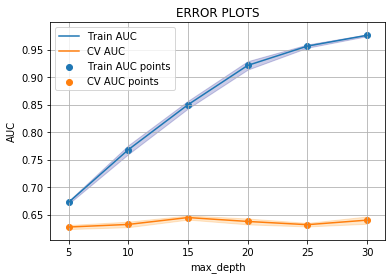

In [121]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#ensemble model 
randomfrst_clf =  RandomForestClassifier(criterion='gini',bootstrap=True, n_jobs=-1,class_weight='balanced')


#tuned hyper parameters 
n_estmatrs_prms = {'max_depth':[5,10,15,20,25,30]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]



#gridsearchcv
grid_search1 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search1.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high varience with low bias, means  max_depth should be high it implies overfit,
* according to the above plot we can choose max_depth = 20,

### <font color='blue'>5.1.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [122]:
#optimal max_depth
optimal_max_depth =20

{'n_estimators': 200}


Text(0.5, 1.0, 'ERROR PLOTS')

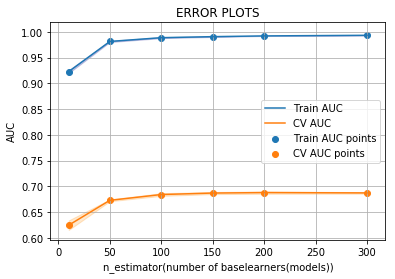

In [123]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#ensemble model 
randomfrst_clf =  RandomForestClassifier(criterion='gini',max_depth=20,bootstrap=True, n_jobs=-1,class_weight='balanced')


#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search2 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search2.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 200, it  implies number of our base models or base learners are(decision trees are better to choose 200) 

## <font color='purple'>5.1.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

In [127]:
#how to plot heatmap between two hyperparameters in python:     https://qiita.com/bmj0114/items/8009f282c99b77780563
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

prms = {'n_estimators':[10,50,100,150,200,300], 'max_depth':[5,10,15,20,25,30]}

rndm_frst_clf = RandomForestClassifier(criterion='gini',bootstrap=True, class_weight='balanced')
grid_search3 = GridSearchCV(rndm_frst_clf, prms, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)

grid_search3.fit(X_tra, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                             

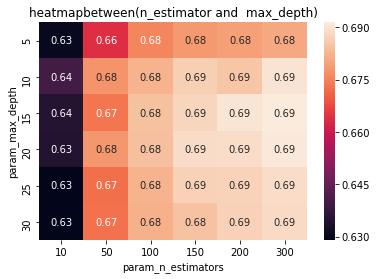

In [128]:
df1 = pd.DataFrame(grid_search3.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmapbetween(n_estimator and  max_depth)')
sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 15 according to the AUC score

## 5.1.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [129]:
#best hyperparameter
best_max_depth = 15
best_n_estimators = 200

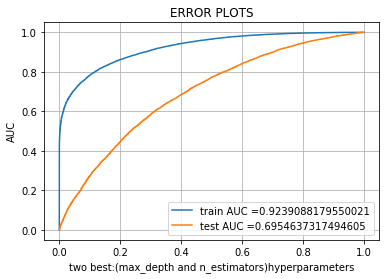

In [130]:
#ensemble model  classifier
rndmfrst_clf =  RandomForestClassifier(n_estimators=200,criterion='gini',max_depth=15,bootstrap=True, n_jobs=-1,class_weight='balanced')
rndmfrst_clf.fit(X_tra, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,rndmfrst_clf.predict_proba(X_tra)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,rndmfrst_clf.predict_proba(X_tes)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.92 and AUC on Test data = 0.69

### <font color='purple'>5.1.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 6180  1246]
 [ 6586 35029]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 2442  3017]
 [ 5907 24686]]


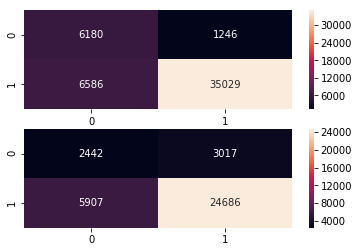

In [134]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, rndmfrst_clf.predict(X_tra))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,rndmfrst_clf.predict(X_tes))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  35029 true positive values,6586 fpr values,6180 tnr values,1246 fnr values 
* in test confusion matrix we have  24686 true positive values, 5907 fpr values, 2442 tnr values,3017 fnr values 

# <font color='green'>5.2 GBDT Classifier on SET1</font>

### <font color='blue'>Important points :</font>
* XG BOOST implemented GBDT is better than the sklearn implemented GBDT because there we don't have  column sampling in sklearn implemented GBDT, xg boost is completly  different package
* sklearn implemented GBDT is very slow, xgboost gbdt also interface with sklearn.
* and XG boost GBDT provides (rowsampling+columnsampling)randomization
* in gradient boost we want our decision trees with shallow trees.

### <font color='blue'>5.2.1 Hyper parameter tuning:(Max_depth)</font>

* objective for binary classification ='binary:logistic',for multicalss:"multi:softprob", for regression"reg:linear"
* booster='gbtree'

{'max_depth': 10}


Text(0.5, 1.0, 'ERROR PLOTS')

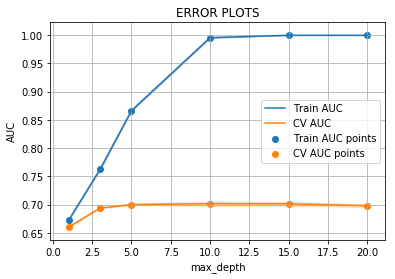

In [141]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


import xgboost as xgb


#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=-1)   

#tuned hyper parameters 
n_estmatrs_prms = {'max_depth':[1,3,5,10,15,20]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]



#gridsearchcv
grid_search1 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search1.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high bias with low varience, means  max_depth should be low shallow trees.
* according to the above plot we can choose max_depth = 5,

### <font color='blue'>5.2.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [140]:
#optimal max_depth
optimal_max_depth =5

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

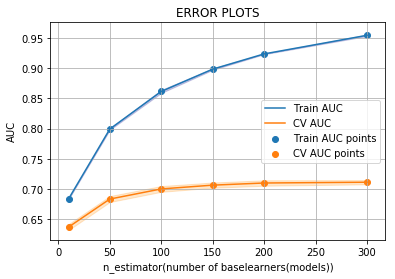

In [141]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit

import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=-1)  

#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search2 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=-1)
grid_search2.fit(X_tra, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 250, it  implies number of our base models or base learners are(decision trees are better to choose 250) 

## <font color='purple'>5.2.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

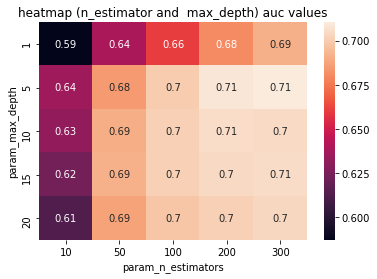

In [157]:
#how to plot heatmap between two hyperparameters in python:     https://qiita.com/bmj0114/items/8009f282c99b77780563
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


prms = {'max_depth':[1,5,10,15,20],'n_estimators':[10,50,100,200,300]}   

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  

grid_search = GridSearchCV(xbg_model, prms, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)

grid_search.fit(X_tra, y_train)



df1 = pd.DataFrame(grid_search.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmap (n_estimator and  max_depth) auc values')

sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 5 according to the AUC score

## 5.2.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [158]:
#best hyperparameter
best_max_depth = 5
best_n_estimators = 200

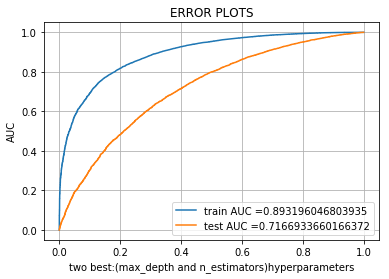

In [160]:
#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(max_depth=5,n_estimators=200,learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  
xbg_model.fit(X_tra, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,xbg_model.predict_proba(X_tra)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,xbg_model.predict_proba(X_tes)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.89 and AUC on Test data = 0.71

### <font color='purple'>5.2.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[  337  7089]
 [    9 41606]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[   83  5376]
 [   50 30543]]


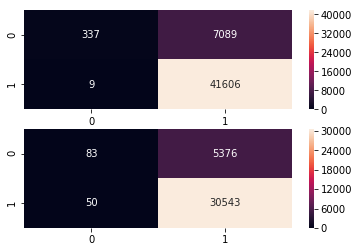

In [162]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, xbg_model.predict(X_tra))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,xbg_model.predict(X_tes))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  41606 true positive values, 9 fpr values,337   tnr values,7089 fnr values 
* in test confusion matrix we have  30543 true positive values,50  fpr values, 83   tnr values,5376 fnr values 


# 6.Creating (SET2):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF) and title(TFIDF)</font>
 #  <font color='green'>Applying Random Foreston set2</font>

In [171]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#concatinating features
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf,X_train_title_tfidf, X_train_state_final_mat,X_train_projcat_final_mat,X_train_projsubcat_final_mat,X_train_projgrade_final_mat, X_train_tchrprfx_final_mat,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm)).tocsr()
X_cr1 = hstack((X_cv_essay_tfidf,X_cv_title_tfidf, X_cv_state_final_mat,X_cv_projcat_final_mat, X_cv_projsubcat_final_mat,X_cv_projgrade_final_mat , X_cv_tchrprfx_final_mat,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm )).tocsr()
X_te1 = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_final_mat,X_test_projcat_final_mat,X_test_projsubcat_final_mat,X_test_projgrade_final_mat,X_test_tchrprfx_final_mat, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm)).tocsr()

print("*"*60)
print("Final set1 Data matrix:")
print(X_tr1.shape, y_train.shape)
print(X_cr1.shape, y_cv.shape)
print(X_te1.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 9767) (49041,)
(24155, 9767) (24155,)
(36052, 9767) (36052,)


### <font color='orange'>Apply Ensemble models (Random Forest and GBDT) on our above  preprocessed data</font>
# <font color='green'>6.1 RandomForest Classifier on SET2</font>


### <font color='blue'>Important points:</font>

* Randome forest : we have to perform hyper parameter tuning on n_estimator and min_samplesplit
    
* always keep 'max_depth' =high because, Decision trees models should with high varience   

* so then Random Forest(aggregation will decreses) high varience to low varience with low bias.

* boot_strap = always keep True

### <font color='blue'>6.1.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 10}


Text(0.5, 1.0, 'ERROR PLOTS')

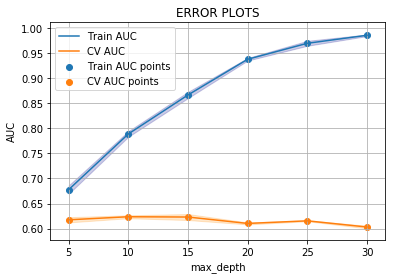

In [175]:
# terminateworker error: https://github.com/scikit-learn/scikit-learn/issues/6147
#ensemble model 
randomfrst_clf =  RandomForestClassifier(criterion='gini',bootstrap=True,class_weight='balanced',n_jobs=8)

#tuned hyper parameters
n_estmatrs_prms = {'max_depth':[5,10,15,20,25,30]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]

#gridsearchcv
grid_search2 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high varience with low bias, means  max_depth should be high it implies overfit,
* according to the above plot we can choose max_depth = 25

### <font color='blue'>6.1.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [176]:
#optimal max_depth
optimal_max_depth = 25

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

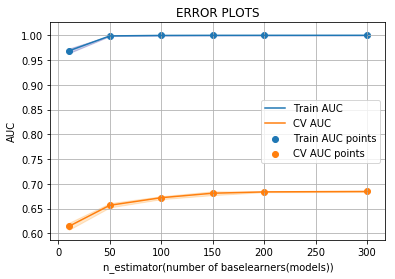

In [177]:

#ensemble model Random forest
randomfrst_clf =  RandomForestClassifier(criterion='gini',max_depth=25,bootstrap=True, n_jobs=8,class_weight='balanced')


#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search3 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search3.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search3.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search3.cv_results_['mean_train_score']
train_auc_std= grid_search3.cv_results_['std_train_score']
cv_auc = grid_search3.cv_results_['mean_test_score'] 
cv_auc_std= grid_search3.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 250, it  implies number of our base models or base learners are(decision trees are better to choose 250) 

## <font color='purple'>6.1.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

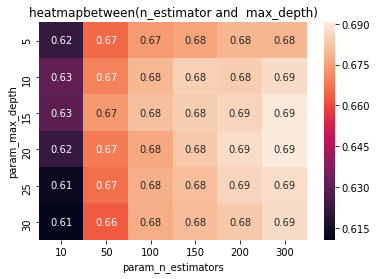

In [178]:
#how to plot heatmap between two hyperparameters in python:     https://qiita.com/bmj0114/items/8009f282c99b77780563
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

prms = {'n_estimators':[10,50,100,150,200,300], 'max_depth':[5,10,15,20,25,30]}

rndm_frst_clf = RandomForestClassifier(criterion='gini',bootstrap=True, class_weight='balanced',n_jobs=8)
grid_search4 = GridSearchCV(rndm_frst_clf, prms, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=1)
grid_search4.fit(X_tr1, y_train)

df1 = pd.DataFrame(grid_search4.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmapbetween(n_estimator and  max_depth)')
sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 20 according to the AUC score

## 6.1.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [179]:
#best hyperparameter
best_max_depth = 20
best_n_estimators = 200

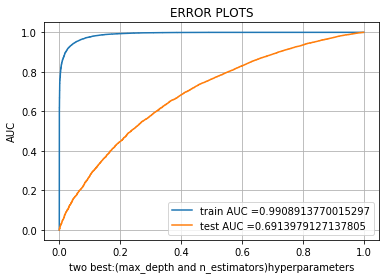

In [182]:
#ensemble model  classifier
rndmfrst_clf =  RandomForestClassifier(n_estimators=200,max_depth=20,criterion='gini',bootstrap=True, n_jobs=-1,class_weight='balanced')
rndmfrst_clf.fit(X_tr1, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,rndmfrst_clf.predict_proba(X_tr1)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,rndmfrst_clf.predict_proba(X_te1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.99 and AUC on Test data = 0.69

### <font color='purple'>6.1.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[  254  7172]
 [    5 41610]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[    7  5452]
 [    9 30584]]


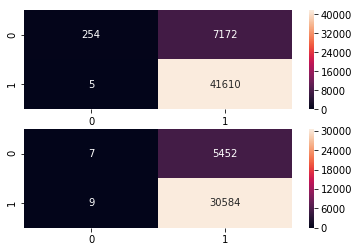

In [183]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, rndmfrst_clf.predict(X_tr1))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,rndmfrst_clf.predict(X_te1))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  41610 true positive values, 5 fpr values,254 tnr values,7172 fnr values 
* in test confusion matrix we have  30584 true positive values,9 fpr values, 7 tnr values,5452 fnr values 

# <font color='green'>6.2 GBDT Classifier on SET2</font>

### <font color='blue'>Important points :</font>
* XG BOOST implemented GBDT is better than the sklearn implemented GBDT because there we don't have  column sampling in sklearn implemented GBDT, xg boost is completly  different package
* sklearn implemented GBDT is very slow, xgboost gbdt also interface with sklearn.
* and XG boost GBDT provides (rowsampling+columnsampling)randomization
* in gradient boost we want our decision trees with shallow trees.

### <font color='blue'>6.2.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 15}


Text(0.5, 1.0, 'ERROR PLOTS')

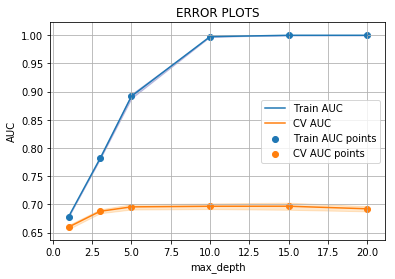

In [185]:
import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)   

#tuned hyper parameters 
n_estmatrs_prms = {'max_depth':[1,3,5,10,15,20]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]



#gridsearchcv
grid_search1 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search1.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high bias with low varience, means  max_depth should be low shallow trees.
* according to the above plot we can choose max_depth = 3

### <font color='blue'>6.2.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [189]:
#optimal max_depth
optimal_max_depth = 3

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

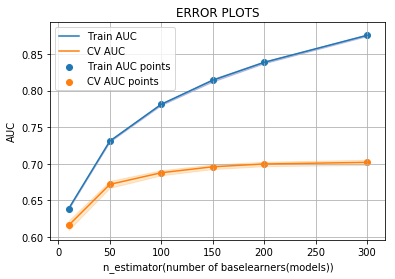

In [188]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit

import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)  

#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search2 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr1, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 200, it  implies number of our base models or base learners are(decision trees are better to choose 200) 

## <font color='purple'>6.2.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

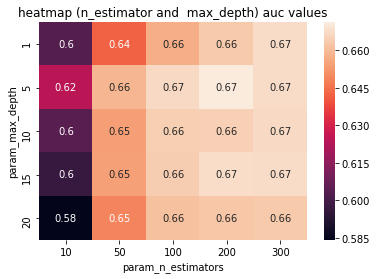

In [192]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

prms = {'max_depth':[1,5,10,15,20],'n_estimators':[10,50,100,200,300]}   

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  

grid_search = GridSearchCV(xbg_model, prms, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)

grid_search.fit(X_tr1, y_train)

 

df1 = pd.DataFrame(grid_search.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmap (n_estimator and  max_depth) auc values')

sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 5 according to the AUC score

## 6.2.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [193]:
best_max_depth = 5
best_n_estimators=200

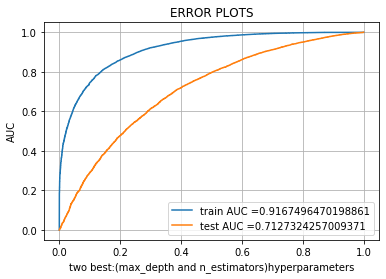

In [260]:
#ensemble model XGboost GBDT
import xgboost as xgb

xbg_model = xgb.XGBClassifier(max_depth=5,n_estimators=200,learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  
xbg_model.fit(X_tr1, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,xbg_model.predict_proba(X_tr1)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,xbg_model.predict_proba(X_te1)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.91 and AUC on Test data = 0.72

### <font color='purple'>6.2.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[  539  6887]
 [    4 41611]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[   75  5384]
 [   59 30534]]


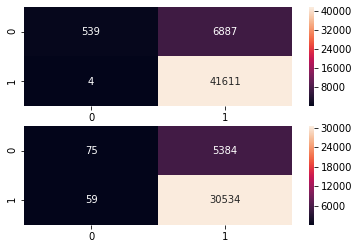

In [261]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, xbg_model.predict(X_tr1))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,xbg_model.predict(X_te1))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  41611 true positive values, 4 fpr values,539   tnr values,6887 fnr values 
* in test confusion matrix we have  30534 true positive values,59 fpr values, 75 tnr values,5384 fnr values 


# 7.Creating (SET3):
# <font color='green'> data matix with all categorical, all numerical,essay(AVG W2V) and title(AVG W2V)</font>
 #  <font color='green'>Applying Random Foreston set3</font>

In [246]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix
from scipy import sparse

#concatinating features
X_t = np.hstack((X_train_essay_avgw2v,X_train_title_avgw2v, X_train_state_final_mat,X_train_projcat_final_mat,X_train_projsubcat_final_mat,X_train_projgrade_final_mat, X_train_tchrprfx_final_mat,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm))
X_c = np.hstack(( X_cv_essay_avgw2v,X_cv_title_avgw2v, X_cv_state_final_mat,X_cv_projcat_final_mat, X_cv_projsubcat_final_mat,X_cv_projgrade_final_mat , X_cv_tchrprfx_final_mat,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm ))
X_tt = np.hstack((X_test_essay_avgw2v,X_test_title_avgw2v, X_test_final_mat,X_test_projcat_final_mat,X_test_projsubcat_final_mat,X_test_projgrade_final_mat,X_test_tchrprfx_final_mat, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm))

X_tr3 =  sparse.csr_matrix(X_t)
X_cr3 =  sparse.csr_matrix(X_c)
X_te3 =  sparse.csr_matrix(X_tt)

print("*"*60)
print("Final set1 Data matrix:")
print(X_tr3.shape, y_train.shape)
print(X_cr3.shape, y_cv.shape)
print(X_te3.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 113) (49041,)
(24155, 113) (24155,)
(36052, 113) (36052,)


### <font color='orange'>Apply Ensemble models (Random Forest and GBDT) on our above  preprocessed data</font>
# <font color='green'>7.1 RandomForest Classifier on SET3</font>


### <font color='blue'>Important points:</font>

* Randome forest : we have to perform hyper parameter tuning on n_estimator and min_samplesplit
    
* always keep 'max_depth' =high because, Decision trees models should with high varience   

* so then Random Forest(aggregation will decreses) high varience to low varience with low bias.

* boot_strap = always keep True

### <font color='blue'>7.1.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

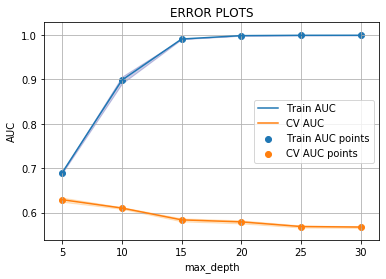

In [247]:
# terminateworker error: https://github.com/scikit-learn/scikit-learn/issues/6147
#ensemble model 
randomfrst_clf =  RandomForestClassifier(criterion='gini',bootstrap=True,class_weight='balanced',n_jobs=8)

#tuned hyper parameters
n_estmatrs_prms = {'max_depth':[5,10,15,20,25,30]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]

#gridsearchcv
grid_search2 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high varience with low bias, means  max_depth should be high it implies overfit,
* according to the above plot we can choose max_depth = 24

### <font color='blue'>7.1.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [249]:
#optimal max_depth = 24
optimal_max_depth = 24

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

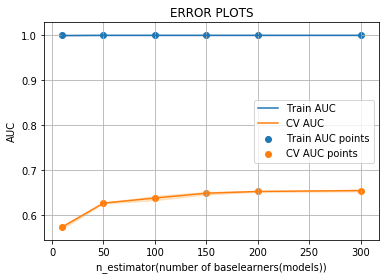

In [248]:

#ensemble model Random forest
randomfrst_clf =  RandomForestClassifier(criterion='gini',max_depth=24,bootstrap=True, n_jobs=8,class_weight='balanced')


#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search3 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search3.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search3.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search3.cv_results_['mean_train_score']
train_auc_std= grid_search3.cv_results_['std_train_score']
cv_auc = grid_search3.cv_results_['mean_test_score'] 
cv_auc_std= grid_search3.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 250, it  implies number of our base models or base learners are(decision trees are better to choose 150) 

## <font color='purple'>7.1.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

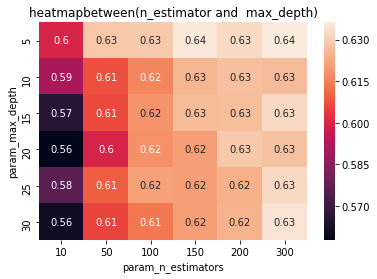

In [251]:
#how to plot heatmap between two hyperparameters in python:     https://qiita.com/bmj0114/items/8009f282c99b77780563
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

prms = {'n_estimators':[10,50,100,150,200,300], 'max_depth':[5,10,15,20,25,30]}

rndm_frst_clf = RandomForestClassifier(criterion='gini',bootstrap=True, class_weight='balanced',n_jobs=-1)
grid_search4 = GridSearchCV(rndm_frst_clf, prms, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
grid_search4.fit(X_tr3,y_train)

df1 = pd.DataFrame(grid_search4.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmapbetween(n_estimator and  max_depth)')
sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 150 and max_depth = 15 according to the AUC score

## 7.1.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [252]:
#best hyperparameter
best_max_depth = 15
best_n_estimators = 150

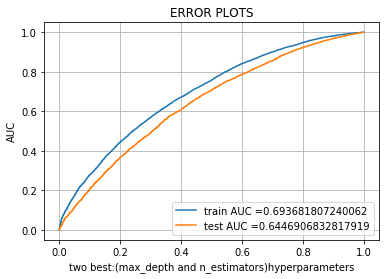

In [255]:
#ensemble model  classifier
rndmfrst_clf =  RandomForestClassifier(n_estimators=150,max_depth=5,criterion='gini',bootstrap=True, n_jobs=-1,class_weight='balanced')
rndmfrst_clf.fit(X_tr3, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,rndmfrst_clf.predict_proba(X_tr3)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,rndmfrst_clf.predict_proba(X_te3)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.69 and AUC on Test data = 0.64

### <font color='purple'>7.1.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 4527  2899]
 [13959 27656]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 2597  2862]
 [ 8259 22334]]


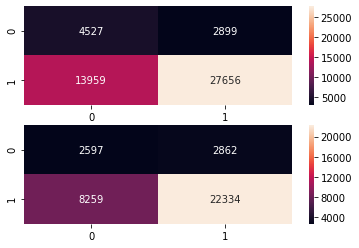

In [256]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, rndmfrst_clf.predict(X_tr3))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,rndmfrst_clf.predict(X_te3))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  27656 true positive values, 13959  fpr values,4527   tnr values,2899 fnr values 
* in test confusion matrix we have  22334 true positive values,8259  fpr values, 2597   tnr values,2862 fnr values 

# <font color='green'>7.2 GBDT Classifier on SET3</font>

### <font color='blue'>Important points :</font>
* XG BOOST implemented GBDT is better than the sklearn implemented GBDT because there we don't have  column sampling in sklearn implemented GBDT, xg boost is completly  different package
* sklearn implemented GBDT is very slow, xgboost gbdt also interface with sklearn.
* and XG boost GBDT provides (rowsampling+columnsampling)randomization
* in gradient boost we want our decision trees with shallow trees.

### <font color='blue'>7.2.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

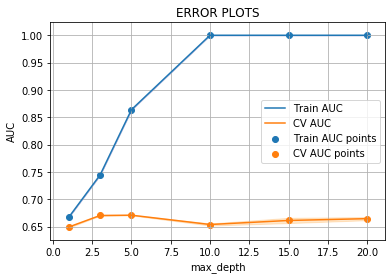

In [262]:
import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)   

#tuned hyper parameters 
n_estmatrs_prms = {'max_depth':[1,3,5,10,15,20]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]



#gridsearchcv
grid_search1 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search1.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high bias with low varience, means  max_depth should be low shallow trees.
* according to the above plot we can choose max_depth = 2

### <font color='blue'>7.2.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [263]:
#optimal_max_depth
optimal_max_depth = 2

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

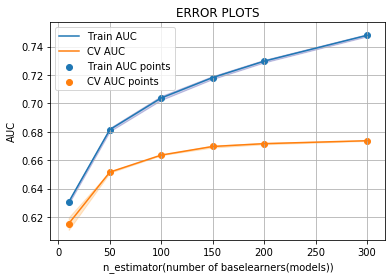

In [264]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit

import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(max_depth=2,learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)  

#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search2 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr3, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 240, it  implies number of our base models or base learners are(decision trees are better to choose 240) 

## <font color='purple'>7.2.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

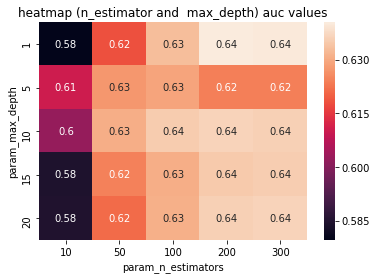

In [267]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

prms = {'max_depth':[1,5,10,15,20],'n_estimators':[10,50,100,200,300]}   

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  

grid_search = GridSearchCV(xbg_model, prms, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)

grid_search.fit(X_tr3,y_train)

 

df1 = pd.DataFrame(grid_search.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmap (n_estimator and  max_depth) auc values')

sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 2 according to the AUC score

## 7.2.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [268]:
best_max_depth = 2
best_n_estimators=200

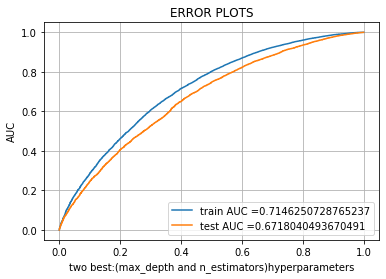

In [269]:
#ensemble model XGboost GBDT
import xgboost as xgb

xbg_model = xgb.XGBClassifier(max_depth=2,n_estimators=200,learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  
xbg_model.fit(X_tr3, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,xbg_model.predict_proba(X_tr3)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,xbg_model.predict_proba(X_te3)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.71 and AUC on Test data = 0.67

### <font color='purple'>7.2.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[   74  7352]
 [    9 41606]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[   15  5444]
 [    9 30584]]


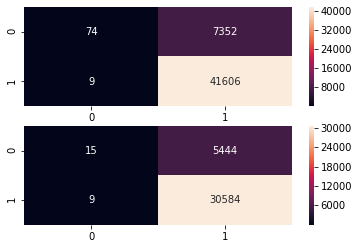

In [270]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, xbg_model.predict(X_tr3))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,xbg_model.predict(X_te3))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  41606 true positive values, 9 fpr values,74 tnr values,7352 fnr values 
* in test confusion matrix we have  30584 true positive values,9 fpr values, 15   tnr values,5444 fnr values 


# 8.Creating (SET4):
# <font color='green'> data matix with all categorical, all numerical,essay(TFIDF W2V) and title(TFIDF W2V)</font>
 #  <font color='green'>Applying Random Foreston set4</font>

In [274]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
#https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix
from scipy import sparse

#concatinating features
X_tr11 = np.hstack((X_train_essay_tfidfw2v,X_train_title_tfidfw2v, X_train_state_final_mat,X_train_projcat_final_mat,X_train_projsubcat_final_mat,X_train_projgrade_final_mat, X_train_tchrprfx_final_mat,X_train_prvs_posted_prjcts_norm, X_train_price_norm,X_train_quantity_norm))
X_cv11 = np.hstack(( X_cv_essay_tfidfw2v,X_cv_title_tfidfw2v, X_cv_state_final_mat,X_cv_projcat_final_mat, X_cv_projsubcat_final_mat,X_cv_projgrade_final_mat , X_cv_tchrprfx_final_mat,  X_cv_prvs_posted_prjcts_norm , X_cv_price_norm, X_cv_quantity_norm ))
X_test1 = np.hstack((X_test_essay_tfidfw2v,X_test_title_tfidfw2v, X_test_final_mat,X_test_projcat_final_mat,X_test_projsubcat_final_mat,X_test_projgrade_final_mat,X_test_tchrprfx_final_mat, X_test_prvs_posted_prjcts_norm, X_test_price_norm,X_test_quantity_norm))

X_tr4 =  sparse.csr_matrix(X_tr11)
X_cr4 =  sparse.csr_matrix(X_cv11)
X_te4 =  sparse.csr_matrix(X_test1)

print("*"*60)
print("Final set1 Data matrix:")
print(X_tr4.shape, y_train.shape)
print(X_cr4.shape, y_cv.shape)
print(X_te4.shape, y_test.shape)

************************************************************
Final set1 Data matrix:
(49041, 113) (49041,)
(24155, 113) (24155,)
(36052, 113) (36052,)


### <font color='orange'>Apply Ensemble models (Random Forest and GBDT) on our above  preprocessed data</font>
# <font color='green'>8.1 RandomForest Classifier on SET4</font>


### <font color='blue'>Important points:</font>

* Randome forest : we have to perform hyper parameter tuning on n_estimator and min_samplesplit
    
* always keep 'max_depth' =high because, Decision trees models should with high varience   

* so then Random Forest(aggregation will decreses) high varience to low varience with low bias.

* boot_strap = always keep True

### <font color='blue'>8.1.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

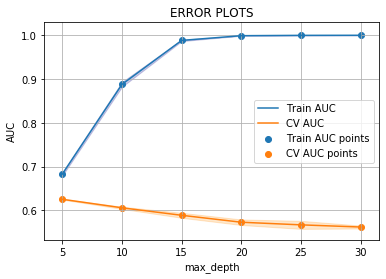

In [275]:
# terminateworker error: https://github.com/scikit-learn/scikit-learn/issues/6147
#ensemble model 
randomfrst_clf =  RandomForestClassifier(criterion='gini',bootstrap=True,class_weight='balanced',n_jobs=8)

#tuned hyper parameters
n_estmatrs_prms = {'max_depth':[5,10,15,20,25,30]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]

#gridsearchcv
grid_search2 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high varience with low bias, means  max_depth should be high it implies overfit,
* according to the above plot we can choose max_depth = 20

### <font color='blue'>8.1.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [276]:
#optimal_max_depth
optimal_max_depth = 20

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

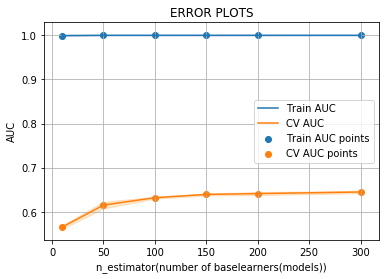

In [277]:

#ensemble model Random forest
randomfrst_clf =  RandomForestClassifier(criterion='gini',max_depth=24,bootstrap=True, n_jobs=8,class_weight='balanced')


#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search3 = GridSearchCV(randomfrst_clf, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search3.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search3.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search3.cv_results_['mean_train_score']
train_auc_std= grid_search3.cv_results_['std_train_score']
cv_auc = grid_search3.cv_results_['mean_test_score'] 
cv_auc_std= grid_search3.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 150, it  implies number of our base models or base learners are(decision trees are better to choose 150) 

## <font color='purple'>8.1.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

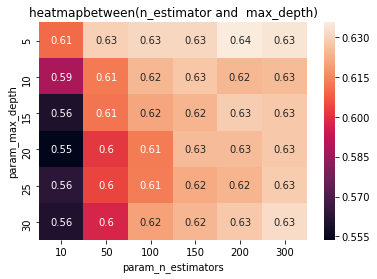

In [279]:
#how to plot heatmap between two hyperparameters in python:     https://qiita.com/bmj0114/items/8009f282c99b77780563
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

prms = {'n_estimators':[10,50,100,150,200,300], 'max_depth':[5,10,15,20,25,30]}

rndm_frst_clf = RandomForestClassifier(criterion='gini',bootstrap=True, class_weight='balanced',n_jobs=-1)
grid_search4 = GridSearchCV(rndm_frst_clf, prms, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)
grid_search4.fit(X_tr4,y_train)

df1 = pd.DataFrame(grid_search4.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmapbetween(n_estimator and  max_depth)')
sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 15 according to the AUC score

## 8.1.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [281]:
#best hyperparameter
best_max_depth = 10
best_n_estimators = 300

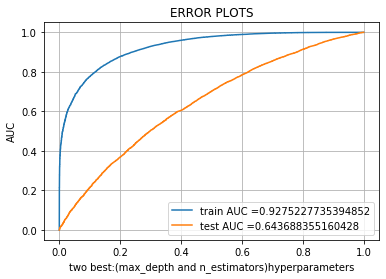

In [286]:
#ensemble model  classifier
rndmfrst_clf =  RandomForestClassifier(n_estimators=300,max_depth=10,criterion='gini',bootstrap=True, n_jobs=-1,class_weight='balanced')
rndmfrst_clf.fit(X_tr4, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,rndmfrst_clf.predict_proba(X_tr4)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,rndmfrst_clf.predict_proba(X_te4)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.92 and AUC on Test data = 0.64

### <font color='purple'>8.1.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[ 5620  1806]
 [ 4098 37517]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[ 1358  4101]
 [ 3494 27099]]


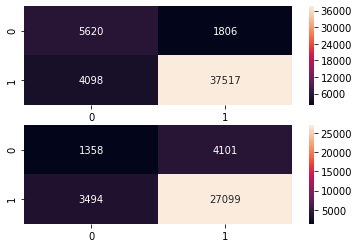

In [287]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, rndmfrst_clf.predict(X_tr4))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,rndmfrst_clf.predict(X_te4))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  37517 true positive values, 4098  fpr values,5620   tnr values,1806 fnr values 
* in test confusion matrix we have  27099 true positive values,3494  fpr values, 1358   tnr values,4101 fnr values 

# <font color='green'>8.2 GBDT Classifier on SET4</font>

### <font color='blue'>Important points :</font>
* XG BOOST implemented GBDT is better than the sklearn implemented GBDT because there we don't have  column sampling in sklearn implemented GBDT, xg boost is completly  different package
* sklearn implemented GBDT is very slow, xgboost gbdt also interface with sklearn.
* and XG boost GBDT provides (rowsampling+columnsampling)randomization
* in gradient boost we want our decision trees with shallow trees.

### <font color='blue'>8.2.1 Hyper parameter tuning:(Max_depth)</font>

{'max_depth': 5}


Text(0.5, 1.0, 'ERROR PLOTS')

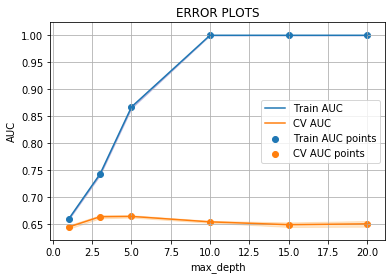

In [288]:
import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)   

#tuned hyper parameters 
n_estmatrs_prms = {'max_depth':[1,3,5,10,15,20]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['max_depth']]



#gridsearchcv
grid_search1 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search1.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search1.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search1.cv_results_['mean_train_score']
train_auc_std= grid_search1.cv_results_['std_train_score']
cv_auc = grid_search1.cv_results_['mean_test_score'] 
cv_auc_std= grid_search1.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("max_depth")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
* basically we have our decision trees with high bias with low varience, means  max_depth should be low shallow trees.
* according to the above plot we can choose max_depth = 3

### <font color='blue'>8.2.2 Hyper parameter tuning : n_estimators(number of base learners or models)</font>

In [289]:
#optimal_max_depth
optimal_max_depth = 3

{'n_estimators': 300}


Text(0.5, 1.0, 'ERROR PLOTS')

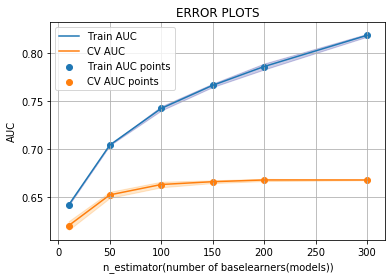

In [290]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit

import xgboost as xgb

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,objective='binary:logistic',booster='gbtree', n_jobs=8)  

#tuned hyper parameters 
n_estmatrs_prms = {'n_estimators':[10,50,100,150,200,300]}
n_estmatrs_prms_plt = [i  for i in n_estmatrs_prms['n_estimators']]



#gridsearchcv
grid_search2 = GridSearchCV(xbg_model, n_estmatrs_prms,scoring='roc_auc', cv=3,return_train_score=True,n_jobs=1)
grid_search2.fit(X_tr4, y_train)    #gridsearch cv fit on train data

print(grid_search2.best_params_)

#finding mean trainscore and std_train score
train_auc= grid_search2.cv_results_['mean_train_score']
train_auc_std= grid_search2.cv_results_['std_train_score']
cv_auc = grid_search2.cv_results_['mean_test_score'] 
cv_auc_std= grid_search2.cv_results_['std_test_score']

plt.plot(n_estmatrs_prms_plt, train_auc, label='Train AUC')
# this code is copied from here: http5306s://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(n_estmatrs_prms_plt, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(n_estmatrs_prms_plt,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(n_estmatrs_prms_plt, train_auc, label='Train AUC points')
plt.scatter(n_estmatrs_prms_plt, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("n_estimator(number of baselearners(models))")
plt.grid()
plt.ylabel("AUC")
plt.title("ERROR PLOTS")

**observation:**
    
* according to the above plot we can choose best n_estimator value = 240, it  implies number of our base models or base learners are(decision trees are better to choose 260) 

## <font color='purple'>8.2.3 Plot Heatmap</font>

**<font color='blue'>plotting heatmap (max_depth) and (n_estimators) by using each cell containing AUC value</font>**

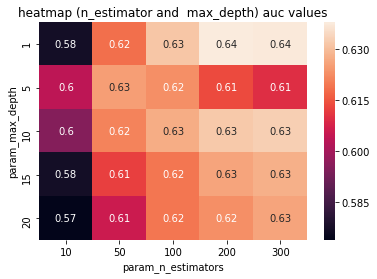

In [296]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

prms = {'max_depth':[1,5,10,15,20],'n_estimators':[10,50,100,200,300]}   

#ensemble model XGboost GBDT
xbg_model = xgb.XGBClassifier(learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  

grid_search = GridSearchCV(xbg_model, prms, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)

grid_search.fit(X_tr4,y_train)

 

df1 = pd.DataFrame(grid_search.cv_results_)   #construc dataframe with all cross_validation parameters
imp_values = df1.groupby(['param_max_depth', 'param_n_estimators']).max()   #group by max_depth and n_wstimators max values

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
imp_values =imp_values.unstack()[['mean_test_score', 'mean_train_score']]   #auc 

plt.title('heatmap (n_estimator and  max_depth) auc values')

sns.heatmap(imp_values.mean_test_score, annot=True)   #annot = True rectanguler dataset

**observation:**
* in  the above heatmap  best n_estimator = 200 and max_depth = 1 according to the AUC score

## 8.2.4Now we can obser our model(with best hyper parameters max_depth and n_estimators) perorme on Train AUROC and Test AUROC curves

In [297]:
best_max_depth = 3
best_n_estimators=200

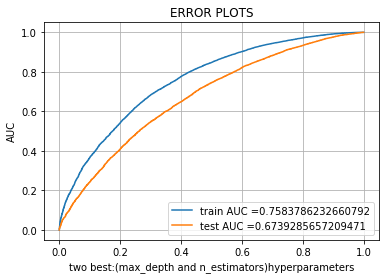

In [298]:
#ensemble model XGboost GBDT
import xgboost as xgb

xbg_model = xgb.XGBClassifier(max_depth=3,n_estimators=200,learning_rate=0.1,objective='binary:logistic',booster='gbtree',n_jobs=-1)  
xbg_model.fit(X_tr4, y_train)


# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the p
# not the predicted outputs 
train_fpr,train_tpr,thresholds = roc_curve(y_train,xbg_model.predict_proba(X_tr4)[:,1])
test_fpr,test_tpr,thresholds = roc_curve(y_test,xbg_model.predict_proba(X_te4)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr))) 
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))                                             
plt.legend()
plt.xlabel("two best:(max_depth and n_estimators)hyperparameters")
plt.ylabel("AUC") 
plt.grid()
plt.title("ERROR PLOTS") 
plt.show()

### Observation:
* train auc and test auc both are above the idel curve
* AUC(performence metric) on train data = 0.75 and AUC on Test data = 0.67

### <font color='purple'>8.2.5 Confusion matrix</font>

confusion matrix using for find  how many true_positive, true_negetive, false_positive and false negetive on train and test data

Train data confusion matrix
Confusion Matrix:
 [[  121  7305]
 [   11 41604]]
****************************************
Test data confusion matrix
Confusion Matrix:
 [[   50  5409]
 [   32 30561]]


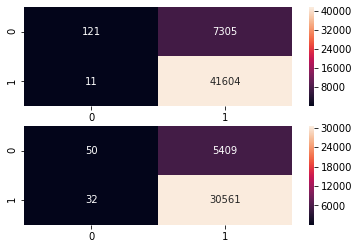

In [299]:
#https://stackoverflow.com/questions/45192483/reason-for-transposed-confusion-matrix-in-heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html

fig=plt.figure(1)
a = fig.add_subplot(211)
from sklearn.metrics import confusion_matrix
print("Train data confusion matrix")
a = confusion_matrix(y_train, xbg_model.predict(X_tr4))     #predicting tpr,fpr,tnr,fnr on y_train of x train data
print("Confusion Matrix:\n",a)
print("*"*40)
sns.heatmap(a,annot = True, fmt='g')    #annot = True rectanguler dataset

b = fig.add_subplot(212)
print("Test data confusion matrix")
b = confusion_matrix(y_test,xbg_model.predict(X_te4))
print("Confusion Matrix:\n",b)
sns.heatmap(b,annot = True, fmt='g')    #annot = True rectanguler dataset

**observation:**
* in above figure 1 we have 2 sub plots 1st subplot implies train data sonfusion matrix, 2 subplot implies test data confusion matrix
* in train confusion matrix we have  41604 true positive values, 11  fpr values,121   tnr values,7305 fnr values 
* in test confusion matrix we have  30561 true positive values,32  fpr values, 50   tnr values,5409 fnr values 

# Summary(Conclusion):

* we have applied ensembel models(Random Forest and XGBOOST GBDT) on our whole vectorized data.
* ensmbe model means goup of  base models (learners)
* in the Random forest = high varience and low bias  convert into low varience and with low bias, it provided row and column sampling
* in the XGBOOST GBDT  = low varience + high bias---> converted into low varience and low bias, it provided row and column sampling

* we can easily chosee our best hyper_parameters(max_depth and n_estimators) using heatmap
* according to the confusion matrix we can say XGBOOST GBDT  is better classification than Random forest classifier.

# Summary in Tabular form

### all results summarized in the tabular form

In [2]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
a = PrettyTable()
a.field_names = ["data/(vect-fts)","Model","best_mx_dpth","bestn_est","AUC"]

a.add_row(["set1(all_nmr,respncdng_ct+essay&tite(BOW))", "Random_Forest",15,200,0.92 ])
a.add_row(["set1(all_nmr,respncdng_ct+essay&tite(BOW))", "XGBOOST_GBDT",5,200,0.89 ])

a.add_row(["set2(all_nmr,respncdng_ctct+essay&tite(TFIDF)", "Random_Forest",20,200,0.99])
a.add_row(["set2(all_nmr,respncdng_ctct+essay&tite(TFIDF)", "XGBOOST_GBDT",5,200,0.91])

a.add_row(["set3(all_nmr,respncdng_ctct+essay&tite(avgw2v))","Random_Forest",5,150,0.69 ])
a.add_row(["set3(all_nmr,respncdng_ctct+essay&tite(avgw2v))","XGBOOST_GBDT",2,200,0.71 ])

a.add_row(["set4(all_nmr,respncdng_ctct+essay&tite(tfidfw2v))", "Random_Forest",10,300,0.92 ])
a.add_row(["set4(all_nmr,respncdng_ctct+essay&tite(tfidfw2v))", "XGBOOST_GBDT",3,200,0.75 ])

print(a)

+---------------------------------------------------+---------------+--------------+-----------+------+
|                  data/(vect-fts)                  |     Model     | best_mx_dpth | bestn_est | AUC  |
+---------------------------------------------------+---------------+--------------+-----------+------+
|     set1(all_nmr,respncdng_ct+essay&tite(BOW))    | Random_Forest |      15      |    200    | 0.92 |
|     set1(all_nmr,respncdng_ct+essay&tite(BOW))    |  XGBOOST_GBDT |      5       |    200    | 0.89 |
|   set2(all_nmr,respncdng_ctct+essay&tite(TFIDF)   | Random_Forest |      20      |    200    | 0.99 |
|   set2(all_nmr,respncdng_ctct+essay&tite(TFIDF)   |  XGBOOST_GBDT |      5       |    200    | 0.91 |
|  set3(all_nmr,respncdng_ctct+essay&tite(avgw2v))  | Random_Forest |      5       |    150    | 0.69 |
|  set3(all_nmr,respncdng_ctct+essay&tite(avgw2v))  |  XGBOOST_GBDT |      2       |    200    | 0.71 |
| set4(all_nmr,respncdng_ctct+essay&tite(tfidfw2v)) | Random_For